# Generation and Calibration (3compartment -> no_arm_CVS)

This notebook walks through the end-to-end workflow for generating, simulating, and calibrating a 3compartment model, then extending to a 0D-1D hybrid.

## Steps overview
1. Open vessel array file for 3compartment (switch to no_arm_CVS) in PhLynx.
2. Generate CellML model from PhLynx (saved to Downloads).
3. Set up `user_inputs_dict` for running the model.
4. Load the model with `SimulationHelper`.
5. Simulate the model and plot outputs.
6. Plot ground-truth data vs. uncalibrated outputs.
7. Add arm vessels in PhLynx and regenerate.
8. Create `obs_data.json` from Python utilities.
9. Create `params_for_id.csv` from Python.
10. Run sensitivity analysis over a large parameter set.
11. Choose the most influential parameters (e.g., top 2).
12. Create a `param_id` object.
13. Calibrate with the genetic algorithm.
14. View auto-generated calibration plots.
15. Create additional plots from saved outputs.
16. Calculate PWV with the 0D model.
17. Switch selected vessels to 1D.
18. Generate a new C++ model with 1D vessels.
19. Run the C++ model.
20. Load 0D-1D hybrid results.
21. Plot 0D-1D vs 0D results.
22. Compute PWV for the hybrid and compare to 0D.

> Update paths and filenames to match your environment.


## 0) Set up imports and paths

In [1]:
%load_ext autoreload
%autoreload 2

# Core imports
from pathlib import Path
import os
import sys

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')
import matplotlib.pyplot as plt
try:
    import opencor as oc
except:
    print('opencor not available, open this jupyter notebook with a python version that has opencor installed')
    exit()

print("Imports done")

# Ensure local src is importable
project_root = Path("/home/farg967/Documents/git_projects/circulatory_autogen")
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# Set up paths
resources_dir = project_root / "resources" # TODO: change to the downloads dir if using Phlynx output directly
generated_models_dir = project_root / "generated_models"
param_id_output_dir = project_root / "param_id_output"
this_dir = project_root / "tutorial" / "interactive"
downloads_dir = Path.home() / "Downloads"

print("Paths done")

Imports done
Paths done


## 1) Open vessel array in PhLynx (manual)

- Open the 3compartment  vessel array in PhLynx [LINK_TO_PHLYNX].
- Save/export the vessel array so it is ready for CellML generation. [TO_REPLACE_WITH_GENERATED_CELLML_MODEL]

## 2) Generate CellML in PhLynx (manual)

- In PhLynx, generate the CellML model for the edited vessel array.
- The exported file is typically saved to `~/Downloads`.
- Note the exported filename (e.g., `3compartment.cellml`). 

In [2]:
from utilities.utility_funcs import get_default_inp_data_dict
# Model identifiers
file_prefix = "3compartment"  
input_param_file = f"{file_prefix}_parameters.csv"

# Base user inputs (this shows all the settings that can be changed)
inp_data_dict = get_default_inp_data_dict(file_prefix, input_param_file, resources_dir)

print('inp_data_dict set')
import pprint
pprint.pprint(inp_data_dict)


inp_data_dict set
{'DEBUG': False,
 'do_ia': False,
 'dt': 0.01,
 'external_modules_dir': None,
 'file_prefix': '3compartment',
 'generated_models_dir': '/home/farg967/Documents/git_projects/circulatory_autogen/src/parsers/../../generated_models',
 'generated_models_subdir': '/home/farg967/Documents/git_projects/circulatory_autogen/src/parsers/../../generated_models/3compartment',
 'ia_options': {'method': 'Laplace'},
 'input_param_file': '3compartment_parameters.csv',
 'model_path': '/home/farg967/Documents/git_projects/circulatory_autogen/src/parsers/../../generated_models/3compartment/3compartment.cellml',
 'model_type': 'cellml_only',
 'optimiser_options': {},
 'param_id_output_dir': '/home/farg967/Documents/git_projects/circulatory_autogen/src/parsers/../../param_id_output',
 'parameters_csv_abs_path': '/home/farg967/Documents/git_projects/circulatory_autogen/resources/3compartment_parameters.csv',
 'pre_time': None,
 'resources_dir': '/home/farg967/Documents/git_projects/circulat

In [3]:
from scripts.script_generate_with_new_architecture import generate_with_new_architecture
import shutil

# Generate directly from resources CSVs
success = generate_with_new_architecture(inp_data_dict=inp_data_dict)
if not success:
    raise RuntimeError("Model generation failed")
else:
    print('Model generation successful')



Generating model files at /home/farg967/Documents/git_projects/circulatory_autogen/src/parsers/../../generated_models/3compartment
Generating CellML file 3compartment_units.cellml
Generating CellML file 3compartment.cellml
writing units mapping
writing imports
writing vessel mappings
writing environment to sum venous input flows
writing environment to sum generic junctions input flows
writing environment to sum generic junctions input flows :: SUCCESSFUL
writing environment to apply operations for multiports
writing variable access
writing global params variable access
writing mappings between computational environment and modules
writing mappings between computational environment and modules for global parameters
writing mappings between constant params
writing writing time mappings between environment and modules
Generating CellML file 3compartment_parameters.cellml
Generating modules file 3compartment_modules.cellml
Model generation complete.
Checking Status of Model
The method "par

## 3) Load the model with SimulationHelper

Use the solver wrapper to load the CellML model and prepare a simulation helper.

/home/farg967/software/OpenCOR-0-8-1-Linux/Python/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/farg967/software/OpenCOR-0-8-1-Linux/Python/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/farg967/software/OpenCOR-0-8-1-Linux/Python/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/farg967/software/OpenCOR-0-8-1-Linux/Python/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subno

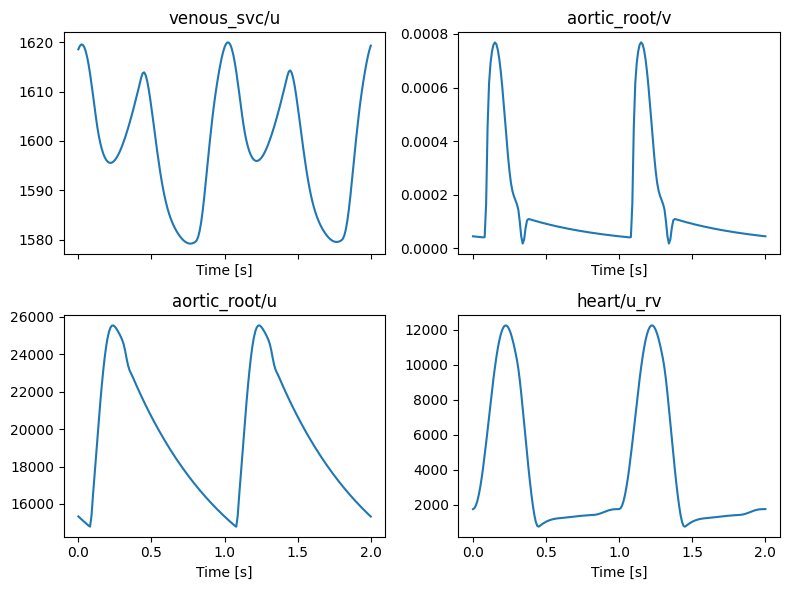

In [4]:
from solver_wrappers import get_simulation_helper_from_inp_data_dict

# Simulation settings
inp_data_dict["sim_time"] = 2 # the 2 seconds we care about
inp_data_dict["pre_time"] = 20.0 # simulate for 20 seconds to get to periodic steady state

sim_helper = get_simulation_helper_from_inp_data_dict(inp_data_dict)

# Run once and plot a few representative variables
sim_helper.run()
variables_to_plot = [
    "venous_svc/u",
    "aortic_root/v",
    "aortic_root/u",
    "heart/u_rv",
]

y = sim_helper.get_results(variables_to_plot, flatten=True)
t = sim_helper.get_time()

##### Plotting #####

plot_dir = Path(param_id_output_dir) / "quicklooks"
plot_dir.mkdir(parents=True, exist_ok=True)

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8, 6))
axs = axs.flatten()
for idx, (ax, series, name) in enumerate(zip(axs, y, variables_to_plot)):
    ax.plot(t, series)
    ax.set_title(name)
    ax.set_xlabel("Time [s]")

plt.tight_layout()
plt.savefig(plot_dir / "uncalibrated_outputs.png")
plt.show()

## 4) Plot ground-truth data vs uncalibrated outputs

Load the ground-truth data and compare it to the uncalibrated simulation results.

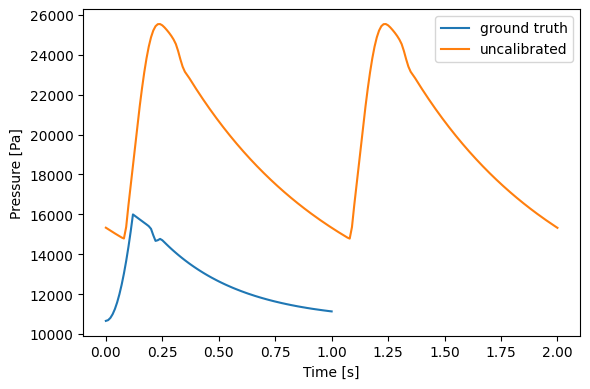

In [5]:
# TODO: update with your ground-truth data file
# Example assumes a CSV with a time column and measurement columns

ground_truth_file = this_dir / "aorta_pressure_temp.txt"
if ground_truth_file.exists():
    gt = pd.read_csv(ground_truth_file, sep="\t")

    time_col = "time_s"
    var_col = "pressure_mmHg"

    time_gt = gt[time_col].to_numpy()
    pressure_pa = gt[var_col].to_numpy() * 133.322  # mmHg -> Pa

    plt.figure(figsize=(6, 4))
    plt.plot(time_gt, pressure_pa, label="ground truth")
    plt.plot(t, y[2], label="uncalibrated")
    plt.xlabel("Time [s]")
    plt.ylabel("Pressure [Pa]")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Ground-truth file not found: {ground_truth_file}")

## 5) Add arm vessels in PhLynx (manual)

- Add arm vessels in PhLynx.
- Regenerate the CellML model.
- If you exported a new CellML file, re-run the copy/generation cell above.

# 6) Create a parameter identification object which will be used to set up your calibration problem

In [6]:
from param_id.paramID import CVS0DParamID

# first create a a param id object which will be used to set up out calibration problem
solver_info = {
    "dt": 0.01,
    "pre_time": 20.0,
    "sim_time": 2.0,
    "solver_type": "cvode",
    "solver_options": {"atol": 1e-6, "rtol": 1e-6},
}

param_id = CVS0DParamID(
    model_path=inp_data_dict["model_path"],
    model_type="cellml_only",
    param_id_method="genetic_algorithm",
    file_name_prefix="3compartment" # name here only needed for saved files
)




# you could also have called the below to use the inp_data_dict created previously
# param_id = CVS0DParamID.from_dict(inp_data_dict)

No optimiser options provided, using default options
Default optimiser options: {'cost_convergence': 0.0001, 'max_patience': 10, 'num_calls_to_function': 10000}


## 7) Set the observable data that you want to calibrate towards

In [8]:
from utilities.obs_data_helpers import ObsDataCreator

# now create the obs data creator object for creating a dictionary that contains the data you will fit towards
obs_data_creator = ObsDataCreator()

# Protocol info (this defines your times and changes of inputs in the experiment)
pre_times = [[20]]
sim_times = [[time_gt]]
obs_dt = time_gt[1]-time_gt[0]
params_to_change = {}
obs_data_creator.add_protocol_info(pre_times, sim_times, params_to_change)

# Data items (fill with your actual observation series)
# Example placeholder (replace with real data)
entry = {
    "variable": "P aortic root",
    "name_for_plotting": "$P_{ao}$",
    "data_type": "series",
    "operation": None,
    "operands": ["aortic_root/u"],
    "unit": "Pa",
    "weight": 1.0,
    "value": pressure_pa,
    "std": pressure_pa*0.1, # assume 10% Coefficient of variation for now
    "obs_dt": obs_dt,
    "experiment_idx": 0,
    "subexperiment_idx": 0,
}
obs_data_creator.add_data_item(entry)
obs_data_dict = obs_data_creator.get_obs_data_dict()

# pprint.pprint(obs_data_dict)

# now add the obs to the param id object
param_id.set_ground_truth_data(obs_data_dict)


Setting ground truth data: {'protocol_info': {'pre_times': [[20]], 'sim_times': [[array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])]], 'params_to_change': {}, 'experiment_labels': ['exp_0']}, 'prediction_items': [], 'data_items': [{'variable': 'P aortic root', 'name_for_plotting': '$P_{ao}$', 'data_type': 'series', 'operation': None, 'operands': ['aortic_root/u'], 'unit'

## 6) Create params_for_id.csv from Python

Define the parameter bounds for identification in a CSV file. Use the same schema as `resources/3compartment_params_for_id.csv`.


In [9]:
# TODO: replace with your full parameter set
params_for_id_dict = [
    {
        "vessel_name": "global",
        "param_name": "q_lv_init",
        "param_type": "const",
        "min": 200e-6,
        "max": 1500e-6,
        "name_for_plotting": "q_{sbv}",
    },
    {
        "vessel_name": "aortic_root",
        "param_name": "C",
        "param_type": "const",
        "min": 1e-9,
        "max": 5e-8,
        "name_for_plotting": "C_{ao}",
    },
]

print(params_for_id_dict)

# now add the params to the param id object
param_id.set_params_for_id(params_for_id_dict)


[{'vessel_name': 'global', 'param_name': 'q_lv_init', 'param_type': 'const', 'min': 0.0002, 'max': 0.0015, 'name_for_plotting': 'q_{sbv}'}, {'vessel_name': 'aortic_root', 'param_name': 'C', 'param_type': 'const', 'min': 1e-09, 'max': 5e-08, 'name_for_plotting': 'C_{ao}'}]
Setting params for id: [{'vessel_name': 'global', 'param_name': 'q_lv_init', 'param_type': 'const', 'min': 0.0002, 'max': 0.0015, 'name_for_plotting': 'q_{sbv}'}, {'vessel_name': 'aortic_root', 'param_name': 'C', 'param_type': 'const', 'min': 1e-09, 'max': 5e-08, 'name_for_plotting': 'C_{ao}'}]
Params for id set: [['g/q_lv_init', 'l/q_lv_init', 'o/q_lv_init', 'b/q_lv_init', 'a/q_lv_init', 'l/q_lv_init'], ['a/C', 'o/C', 'r/C', 't/C', 'i/C', 'c/C', '_/C', 'r/C', 'o/C', 'o/C', 't/C']]


## 7) Sensitivity analysis

Run Sobol sensitivity analysis over a large parameter set and save outputs to a defined directory.


In [ ]:
from sensitivity_analysis.sensitivityAnalysis import SensitivityAnalysis

sa_output_dir = Path(param_id_output_dir) / "sensitivity" / file_prefix
sa_output_dir.mkdir(parents=True, exist_ok=True)

sa_options = {
    "method": "sobol",
    "sample_type": "saltelli",
    "num_samples": 256,
    "output_dir": str(sa_output_dir),
}

model_out_names = ["aortic_root/u", "aortic_root/v"]  # TODO: update

sa_agent = SensitivityAnalysis.from_dict(inp_data_dict)

# TODO, I am up to here!
sa_agent.set_sa_options(sa_options)


sa_agent.set_ground_truth_data(obs_data_dict)
sa_agent.set_params_for_id(params_for_id_dict)

sa_agent.run_sensitivity_analysis(sa_options)
sa_output_dir


AttributeError: 'SensitivityAnalysis' object has no attribute 'set_ground_truth_data'

## 8) View the sensitivity analysis plots

In [ ]:
from IPython.display import Image, display

# Display the first plot from the sensitivity analysis
plot_file = sa_output_dir / "sobol_sensitivity_plot.png"
if plot_file.exists():
    display(Image(filename=plot_file))


## 8) Choose influential parameters

Review the sensitivity analysis outputs (plots/arrays) to choose the most influential parameters (e.g., top 2).


In [ ]:
# TODO: inspect SA outputs in sa_output_dir and pick top parameters
# Example placeholder list:
most_influential_params = [
    "global/q_lv_init",
    "aortic_root/C",
]
most_influential_params


## 9) Parameter identification (genetic algorithm)

Use the genetic algorithm to calibrate model parameters.

$$
\min_{\theta \in \Theta} \; \sum_{i=1}^{N} w_i \lVert y_i^{model}(\theta) - y_i^{obs} \rVert^2
$$

> Replace the objective above with your formal calibration problem as needed.


In [11]:
from param_id.paramID import CVS0DParamID

inp_data_dict["param_id_method"] = "genetic_algorithm"
param_id.set_param_id_method(inp_data_dict["param_id_method"])

# Optimiser options (adjust as needed)
optimiser_options = {
    "num_calls_to_function": 10000,
    "cost_convergence": 0.001,
    "max_patience": 10,
    "cost_type": "MSE",
}

param_id.set_optimiser_options(optimiser_options)

# Run calibration
param_id.run()

# Plot best fit
param_id.simulate_with_best_param_vals()
param_id.plot_outputs()


Running parameter identification across 1 MPI rank(s)
WARNING Running in serial, are you sure you want to be a snail?
Starting param id run (rank 0 coordinating)
parameter name of g/q_lv_init doesn't exist in either constants or statesThe states are:
['systemic_T/v_T', 'systemic_T/q', 'pvn/v', 'pvn/q_C_change', 'par/v', 'par/q_C', 'heart/q_ra', 'heart/q_rv', 'heart/q_la', 'heart/q_lv', 'heart/chi_a', 'heart/v_trv', 'heart/v_puv', 'heart/v_miv', 'heart/v_aov', 'aortic_root/v', 'aortic_root/q_C', 'aortic_root/q_C_d', 'systemic_T/v', 'venous_svc/v', 'venous_svc/q_C_change', '']
the constants are:
['pvn/R', 'pvn/C', 'pvn/u_ext', 'pvn/I', 'pvn/q_C_init', 'pvn/q_us_0', 'pvn/Delta_q_us', 'pvn/Delta_C', 'par/q_0', 'par/R', 'par/C', 'par/I', 'par/u_ext', 'par/u_0', 'global/rho', 'global/T', 'global/q_ra_us', 'global/q_rv_us', 'global/q_la_us', 'global/q_lv_us', 'global/q_ra_init', 'global/q_rv_init', 'global/q_la_init', 'global/q_lv_init', 'global/T_ac', 'global/T_ar', 'global/t_astart', 'globa

/home/farg967/Documents/git_projects/circulatory_autogen/src/param_id/paramID.py:2782: SyntaxWarning: invalid escape sequence '\.'
  self.param_id_obs_file_prefix = re.sub('\.json', '', os.path.split(param_id_obs_path)[1])


NameError: name 'exit' is not defined

## 10) Review calibration outputs

The calibration process saves plots and arrays in the parameter ID output directory. Use this section to generate additional figures.


In [ ]:
output_dir = Path(param_id.output_dir)
print("Outputs saved to:", output_dir)

# Example: load best parameters
best_params_path = output_dir / "best_param_vals.npy"
if best_params_path.exists():
    best_params = np.load(best_params_path)
    best_params
else:
    print("best_param_vals.npy not found")

# TODO: add custom plots using saved outputs in output_dir


## 11) Calculate PWV with the 0D model

Add your preferred PWV computation here.


In [ ]:
# TODO: compute PWV from 0D outputs
# pwv_0d = compute_pwv(sim_helper, ...)
# pwv_0d


## 12) Switch selected vessels to 1D and generate C++ model

Update vessel arrays for 1D coupling and regenerate a C++ model.


In [ ]:
# TODO: update vessel array to set specific vessels to 1D in PhLynx

inp_data_dict_cpp = dict(inp_data_dict)
inp_data_dict_cpp.update({
    "model_type": "cpp",
    "couple_to_1d": True,
    "cpp_generated_models_dir": str(generated_models_dir / file_prefix),
    "cpp_1d_model_config_path": "/path/to/input1d.dat",  # TODO: update
})

# Generate C++ model with 1D coupling
success_cpp = generate_with_new_architecture(False, inp_data_dict_cpp)
if not success_cpp:
    raise RuntimeError("C++ model generation failed")


## 13) Run the C++ model

Use `subprocess` to run the compiled binary for the 0D-1D hybrid.


In [ ]:
import subprocess

# TODO: update binary path and arguments
cpp_run_dir = Path(inp_data_dict_cpp.get("cpp_generated_models_dir", generated_models_dir / file_prefix))
cpp_binary = cpp_run_dir / "run_model"  # placeholder

if cpp_binary.exists():
    result = subprocess.run([str(cpp_binary)], cwd=str(cpp_run_dir), capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)
else:
    print(f"C++ binary not found: {cpp_binary}")


## 14) Load and plot 0D-1D hybrid results

Load the hybrid outputs and compare them to the 0D results.


In [ ]:
# TODO: update with real hybrid output file(s)
hybrid_output_csv = cpp_run_dir / "hybrid_outputs.csv"

if hybrid_output_csv.exists():
    hybrid = pd.read_csv(hybrid_output_csv)
    time_col = "time"  # TODO: update
    hybrid_var = "aortic_root/u"  # TODO: update

    plt.figure(figsize=(6, 4))
    plt.plot(t, y[2], label="0D")
    plt.plot(hybrid[time_col], hybrid[hybrid_var], label="0D-1D hybrid")
    plt.xlabel("Time [s]")
    plt.ylabel(hybrid_var)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Hybrid output not found: {hybrid_output_csv}")


## 15) PWV comparison (0D vs 0D-1D)

Compute PWV for the hybrid outputs and compare with the 0D model.


In [ ]:
# TODO: compute and compare PWV for hybrid outputs
# pwv_hybrid = compute_pwv_from_hybrid(hybrid)
# print("PWV 0D:", pwv_0d)
# print("PWV hybrid:", pwv_hybrid)


## 16) Concise-call hints (commented)

Below are shorter, user-friendly call patterns you can aim to implement as wrappers.


In [ ]:
# generate_model(file_prefix, model_type="cellml_only")
# sim = run_simulation(model_path, dt=0.01, sim_time=2.0, pre_time=20.0)
# plot_outputs(sim, ["aortic_root/u", "aortic_root/v"])
# obs_path = create_obs_data(data, protocol_info, predictions)
# params_path = create_params_for_id(params_df)
# sa_results = run_sensitivity(model_path, obs_path, params_path, output_dir)
# best_params = pick_top_parameters(sa_results, top_k=2)
# param_id = calibrate_model(model_path, obs_path, params_path, method="genetic_algorithm")
# run_cpp_model(cpp_run_dir)
# hybrid = load_hybrid_outputs(cpp_run_dir)
# compare_outputs(uncalibrated, hybrid)
# compare_pwv(pwv_0d, pwv_hybrid)
